In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats
import shapely
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, LineString
from sklearn.preprocessing import MinMaxScaler

In [2]:
grid = gpd.read_file("vectors\\hexagon_500m2.shp")

In [5]:
type(grid)

geopandas.geodataframe.GeoDataFrame

In [6]:
grid.sindex

In [ ]:
raster_list = {'bup': 'GHS_BUILT_S_E2018_epsg26917.tif',
               'hei': 'GHS_BUILT_H_E2020_epsg26917.tif',
               'vol': 'GHS_BUILT_V_E2020_epsg26917.tif',
               'crn': 'GHS_BUILT_C_FUN_E2018_epsg26917.tif',
            'tree':'PROBAV_LC100_2018_Tree_epsg26917.tif',
            'crops':'PROBAV_LC100_2018_Crops_epsg26917.tif',
            'grass':'PROBAV_LC100_2018_Grass_epsg26917.tif',
            'water':'PROBAV_LC100_2018_Water_epsg26917.tif',
            'shrub':'PROBAV_LC100_2018_Shrub_epsg26917.tif'}

In [ ]:
for key in raster_list.keys():
    path_image = 'rasters' + '\\' + raster_list[key]
   
    if key in ['bup', 'hei', 'vol', 'tree', 'crops', 'grass', 'water', 'shrub']:
        zs = zonal_stats(grid, path_image, stats=['min', 'max', 'mean', 'std', 'median', 'majority', 'sum'])
        df = pd.DataFrame(zs).fillna(0)
        df.columns = key + '_' + df.columns
        grid = grid.merge(df, left_index=True, right_index=True)    
       
    elif key in ['crn']:
        
        count = zonal_stats(grid, path_image, stats=['count'])

        if  key == 'crn':
            cmap = {0: 'NRC', 1: 'RES', 2:'COM'}
            zs = zonal_stats(grid, path_image, categorical = True, category_map=cmap)
            df = pd.DataFrame(zs).fillna(0)
            total = df['NRC'] + df['RES'] + df['COM']
            df['NRC'] = df['NRC']/total
            df['RES'] = df['RES']/total
            df['COM'] = df['COM']/total
            new_grid_rs = grid.merge(df, left_index=True, right_index=True)

In [15]:
# Saving the data so we can continue from this part next time
# new_grid_rs = gpd.to_file("vectors\\rs_attributes.shp")
new_grid_rs = gpd.read_file("vectors\\rs_attributes.shp")

In [ ]:
roads = gpd.read_file("vectors\\roads_osm.shp")

In [ ]:
roads.sindex

In [ ]:
explode = gpd.overlay(grid, roads, how='intersection', keep_geom_type=False).explode()
explode.index.names = ['level_1', 'level_2']
explode['sin'] = 0.0

for (level_1, level_2), group in explode.groupby(level=['level_1', 'level_2']):
        try:
            start_pt = LineString(explode['geometry'][level_1][level_2]).coords[0]
            end_pt = LineString(explode['geometry'][level_1][level_2]).coords[-1]
            straight_line = LineString((start_pt, end_pt))
            line = LineString(explode['geometry'][level_1][level_2])

            if straight_line.length == 0:
                sinuosity = 1
            else:
                sinuosity = line.length / (straight_line.length + 0.01)

            explode['sin'][level_1][level_2] = sinuosity 
        
        except:
                explode['sin'][level_1][level_2] = explode['sin'][level_1][level_2 - 1]
        
explode['length'] = explode['geometry'].length

# Lista de atributos a serem transferidos
attributes_to_transfer = ['attributo', 'attributo2', 'attributo3', 'sin', 'length'] ##################

# DataFrame para armazenar os resultados ponderados
weighted_values = pd.DataFrame()

for attribute in attributes_to_transfer:
    # Criar coluna ponderada para o atributo atual
    explode[f'{attribute}_weighted'] = explode[attribute] * explode['length']

    # Calcular a soma ponderada por 'id'
    sum_weighted = explode.groupby('id')[f'{attribute}_weighted'].sum()

    # Calcular a soma total dos comprimentos por 'id'
    sum_length = explode.groupby('id')['length'].sum()

    # Calcular a média ponderada e atribuir ao DataFrame final
    weighted_values[attribute + '_w'] = sum_weighted / sum_length
    weighted_values[attribute + '_sum'] = explode.groupby('id')[attribute].sum()
    weighted_values[attribute + '_min'] = explode.groupby('id')[attribute].min()
    weighted_values[attribute + '_max'] = explode.groupby('id')[attribute].max()
    weighted_values[attribute + '_var'] = explode.groupby('id')[attribute].std()
    
weighted_values['n_roads'] = explode.groupby('id')['length'].count()

# Adicionar as colunas ponderadas ao DataFrame original (s_grid)
new_grid_roads = pd.merge(grid, weighted_values, left_on='id', right_index=True, how='left').fillna(0)

In [8]:
# Saving the data so we can continue from this part next time
# new_grid_roads.to_file("vectors/roads_attributes.shp")
new_grid_roads = gpd.read_file("vectors/roads_attributes.shp")

In [4]:
new_grid_roads.sindex

In [5]:
intersections = gpd.read_file("vectors\\roads_osm_intersections_points.shp")

In [6]:
intersections.sindex

In [7]:
intersections['n_int'] = 0

In [75]:
it = pd.DataFrame(sjoin(new_grid_roads[['id','geometry']], intersections, how="left", op='intersects').groupby('id')['n_int'].count())

In [76]:
it['id'] = it.index
it.index.names = ['']
it = it.merge(new_grid_roads[['id','n_roads']], left_on='id', right_on ='id', how='left').merge(new_grid_rs[['id','bup_sum','geometry']] ,left_on='id', right_on ='id', how='left')

In [77]:
it = gpd.GeoDataFrame(it)

In [80]:
it['d_int_bup'] = it['n_int'] / (it['bup_sum'] + 0.1)
it['d_int_roads'] = it['n_int']  / it['n_roads']

In [82]:
it

,n_int,id,n_roads,bup_sum,geometry,d_int_bup,d_int_roads
0,6,219.0,2.0,0.0,"POLYGON ((510589.025 4817521.265, 510808.360 4...",60.000000,3.000000
1,6,220.0,4.0,7794.0,"POLYGON ((510589.025 4816761.465, 510808.360 4...",0.000770,1.500000
2,12,221.0,3.0,770.0,"POLYGON ((510589.025 4816001.665, 510808.360 4...",0.015582,4.000000
3,12,532.0,11.0,800.0,"POLYGON ((511247.031 4818660.965, 511466.366 4...",0.014998,1.090909
4,18,533.0,8.0,1422.0,"POLYGON ((511247.031 4817901.165, 511466.366 4...",0.012657,2.250000
...,...,...,...,...,...,...,...
53604,0,112857.0,0.0,0.0,"POLYGON ((746155.209 4917814.865, 746374.544 4...",0.000000,NaN
53605,0,112858.0,0.0,0.0,"POLYGON ((746155.209 4917055.065, 746374.544 4...",0.000000,NaN
53606,0,112859.0,0.0,349.0,"POLYGON ((746155.209 4916295.265, 746374.544 4...",0.000000,NaN
53607,12,112860.0,5.0,4894.0,"POLYGON ((746155.209 4915535.465, 746374.544 4...",0.002452,2.400000


In [10]:
# Saving the data so we can continue from this part next time
#it.to_file("vectors/grade_with_intersections_points.shp")
it = gpd.read_file("vectors/grade_with_intersections_points.shp")

In [11]:
it.columns

Index(['n_int', 'id', 'n_roads', 'bup_sum', 'd_int_bup', 'd_int_road',
       'geometry'],
      dtype='object')

In [22]:
it[['d_int_road']].columns = ['d_int_roads']

In [30]:
it.columns = ['id', 'n_int', 'n_roads', 'bup_sum', 'd_int_bup', 'd_int_roads','geometry']

In [31]:
it = it[['id','n_int','n_roads', 'bup_sum', 'd_int_bup','d_int_roads', 'geometry']]

In [32]:
grid_attributes = new_grid_rs.iloc[:,:-1].merge(new_grid_roads.iloc[:,:-1].merge(it[['id','n_int','d_int_bup','d_int_roads','geometry']], left_on = 'id', right_on = 'id', how="left"), left_on = 'id', right_on = 'id', how = 'left')

In [33]:
grid_attributes = grid_attributes.fillna(0)

In [56]:
matrix = pd.read_csv("sheets\grid_distance_matrix.csv")

In [57]:
matrix

,InputID,TargetID,Distance
0,48948,48633,759.985299
1,48948,48949,759.984605
2,48948,49263,759.983909
3,48948,48634,759.985299
4,48948,49264,759.983909
...,...,...,...
321877,48949,48948,759.984605
321878,48949,48634,759.985299
321879,48949,48635,759.985299
321880,48949,49264,759.983909


In [58]:
id_origem = 'InputID'
id_destin = 'TargetID'
data = matrix.merge(grid_attributes, left_on =id_destin, right_on='id')

In [59]:
data

,InputID,TargetID,Distance,id,bup_min,bup_max,bup_mean,bup_sum,bup_std,bup_median,...,length_w,length_sum,length_min,length_max,length_var,n_roads,n_int,d_int_bup,d_int_roads,geometry
0,48948,48633,759.985299,48633.0,0.0,85.0,1.532404,4729.0,7.532867,0.0,...,775.775672,775.775672,775.775672,775.775672,0.000000,1.0,0,0.000000,0.000000,"POLYGON ((611921.964 4890462.065, 612141.300 4..."
1,48317,48633,759.986682,48633.0,0.0,85.0,1.532404,4729.0,7.532867,0.0,...,775.775672,775.775672,775.775672,775.775672,0.000000,1.0,0,0.000000,0.000000,"POLYGON ((611921.964 4890462.065, 612141.300 4..."
2,48318,48633,759.986682,48633.0,0.0,85.0,1.532404,4729.0,7.532867,0.0,...,775.775672,775.775672,775.775672,775.775672,0.000000,1.0,0,0.000000,0.000000,"POLYGON ((611921.964 4890462.065, 612141.300 4..."
3,48632,48633,759.985992,48633.0,0.0,85.0,1.532404,4729.0,7.532867,0.0,...,775.775672,775.775672,775.775672,775.775672,0.000000,1.0,0,0.000000,0.000000,"POLYGON ((611921.964 4890462.065, 612141.300 4..."
4,48634,48633,759.985992,48633.0,0.0,85.0,1.532404,4729.0,7.532867,0.0,...,775.775672,775.775672,775.775672,775.775672,0.000000,1.0,0,0.000000,0.000000,"POLYGON ((611921.964 4890462.065, 612141.300 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321877,49042,49043,759.984587,49043.0,0.0,82.0,4.614024,14082.0,12.484844,0.0,...,247.476207,1823.300070,18.376016,468.919164,16291.543961,13.0,48,0.003409,3.692308,"POLYGON ((612579.970 4817901.165, 612799.306 4..."
321878,49044,49043,759.984587,49043.0,0.0,82.0,4.614024,14082.0,12.484844,0.0,...,247.476207,1823.300070,18.376016,468.919164,16291.543961,13.0,48,0.003409,3.692308,"POLYGON ((612579.970 4817901.165, 612799.306 4..."
321879,48729,49044,759.985281,49044.0,0.0,100.0,7.065436,21811.0,19.354139,0.0,...,234.414372,1404.340982,20.870279,350.167600,14664.483376,10.0,60,0.002751,6.000000,"POLYGON ((612579.970 4817141.365, 612799.306 4..."
321880,48730,49044,759.985281,49044.0,0.0,100.0,7.065436,21811.0,19.354139,0.0,...,234.414372,1404.340982,20.870279,350.167600,14664.483376,10.0,60,0.002751,6.000000,"POLYGON ((612579.970 4817141.365, 612799.306 4..."


In [60]:
NM = data.groupby(id_origem, sort=True).mean()
NM.insert(0,'InputID',NM.index)
NM['id'] = NM[id_origem]
NM.index.names = ['']
NM = NM.reset_index()
NM = NM[new_grid_rs.iloc[:,:-1].columns]
NM

C:\Users\brdia\AppData\Local\Temp\ipykernel_33656\1286888259.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  NM = data.groupby(id_origem, sort=True).mean()


,id,bup_min,bup_max,bup_mean,bup_sum,bup_std,bup_median,bup_majori,hei_min,hei_max,...,water_std,water_medi,water_majo,shrub_min,shrub_max,shrub_mean,shrub_sum,shrub_std,shrub_medi,shrub_majo
0,219,0.0,70.833333,0.863949,2648.500000,5.209017,0.0,0.0,0.0,2.083333,...,0.000000,0.000000,0.000000,0.000000,11.000000,3.764243,229.500000,2.969785,3.416667,0.666667
1,220,0.0,44.333333,0.234140,719.666667,2.198365,0.0,0.0,0.0,1.250000,...,0.000000,0.000000,0.000000,0.000000,11.833333,2.942089,175.833333,2.954742,2.083333,1.000000
2,221,0.0,79.500000,1.562229,4805.333333,7.751377,0.0,0.0,0.0,2.083333,...,0.000000,0.000000,0.000000,0.000000,11.000000,3.457259,211.500000,2.953076,3.000000,1.333333
3,532,0.0,51.500000,0.244081,745.500000,2.267936,0.0,0.0,0.0,2.083333,...,0.000000,0.000000,0.000000,0.000000,11.666667,3.564501,210.500000,2.606098,3.416667,2.000000
4,533,0.0,52.500000,0.484049,1489.000000,3.515801,0.0,0.0,0.0,1.666667,...,0.000000,0.000000,0.000000,0.000000,10.000000,2.674303,158.333333,2.565179,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,112857,0.0,56.000000,0.437661,1339.500000,3.538317,0.0,0.0,0.0,1.666667,...,6.848615,0.000000,0.000000,0.000000,11.666667,4.619557,276.000000,2.763672,4.500000,3.333333
53605,112858,0.0,40.857143,0.254051,776.714286,2.296250,0.0,0.0,0.0,1.428571,...,7.737756,0.857143,0.000000,0.000000,13.428571,5.242304,317.142857,3.546768,4.714286,3.571429
53606,112859,0.0,68.666667,0.643933,1975.500000,4.411888,0.0,0.0,0.0,2.083333,...,16.675112,10.333333,0.000000,0.166667,14.000000,5.091912,307.333333,3.765732,3.750000,2.833333
53607,112860,0.0,61.000000,0.433153,1325.285714,3.307113,0.0,0.0,0.0,2.500000,...,24.450602,9.571429,14.285714,0.000000,16.142857,5.435542,325.428571,4.443251,3.857143,2.000000


In [61]:
DNM = (pd.DataFrame(new_grid_rs.iloc[:,:-1]) - pd.DataFrame(NM))/(pd.DataFrame(new_grid_rs.iloc[:,:-1]) + pd.DataFrame(NM))
DNM = DNM.fillna(0)
DNM['id'] = NM['id']
DNM

,id,bup_min,bup_max,bup_mean,bup_sum,bup_std,bup_median,bup_majori,hei_min,hei_max,...,water_std,water_medi,water_majo,shrub_min,shrub_max,shrub_mean,shrub_sum,shrub_std,shrub_medi,shrub_majo
0,219,0.0,0.001175,-0.396172,-0.398179,-0.122954,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.0,0.214286,0.180376,0.147632,0.058683,0.188119,0.764706
1,220,0.0,0.189024,0.352130,0.353883,0.316155,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.083871,0.384001,0.378498,0.116926,0.484536,0.666667
2,221,0.0,0.050746,-0.737848,-0.739697,-0.391559,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.0,0.083333,0.306668,0.326969,-0.072158,0.400000,0.680000
3,532,0.0,0.282230,0.966384,0.966712,0.796414,1.0,0.0,0.0,0.484363,...,1.0,0.0,0.0,0.0,-0.029412,-0.261938,-0.262369,0.101640,-1.000000,-1.000000
4,533,0.0,0.032258,-0.370717,-0.374250,-0.096654,0.0,0.0,0.0,0.211597,...,0.0,0.0,0.0,0.0,0.166667,0.366747,0.350205,0.053163,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,112857,0.0,0.272727,0.451798,0.455211,0.377386,0.0,0.0,0.0,0.228160,...,-1.0,0.0,0.0,0.0,-0.029412,0.119812,0.096563,-0.037867,0.052632,0.200000
53605,112858,0.0,0.294698,0.362985,0.362229,0.309078,0.0,0.0,0.0,0.272727,...,-1.0,-1.0,0.0,0.0,-0.099415,-0.018994,0.009150,-0.064872,0.029412,0.253731
53606,112859,0.0,0.050691,0.157829,0.160701,0.140782,0.0,0.0,0.0,0.090909,...,-1.0,-1.0,0.0,-1.0,0.096774,-0.155852,-0.127139,-0.022050,-0.111111,-1.000000
53607,112860,0.0,-0.340659,-0.750991,-0.751534,-0.504924,0.0,0.0,0.0,-1.000000,...,-1.0,-1.0,-1.0,0.0,-0.189474,-0.341743,-0.363256,-0.203612,-0.317073,-1.000000


In [62]:
DNM.columns = 'DNM_' + DNM.columns
NM.columns = 'NM_' + NM.columns

In [63]:
DNM = DNM.merge(grid, right_on = 'id', left_on = 'DNM_id', how = 'left')
DNM = DNM.drop('id', axis = 1)
DNM

,DNM_id,DNM_bup_min,DNM_bup_max,DNM_bup_mean,DNM_bup_sum,DNM_bup_std,DNM_bup_median,DNM_bup_majori,DNM_hei_min,DNM_hei_max,...,DNM_water_medi,DNM_water_majo,DNM_shrub_min,DNM_shrub_max,DNM_shrub_mean,DNM_shrub_sum,DNM_shrub_std,DNM_shrub_medi,DNM_shrub_majo,geometry
0,219,0.0,0.001175,-0.396172,-0.398179,-0.122954,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.214286,0.180376,0.147632,0.058683,0.188119,0.764706,"POLYGON ((510589.025 4817521.265, 510808.360 4..."
1,220,0.0,0.189024,0.352130,0.353883,0.316155,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.083871,0.384001,0.378498,0.116926,0.484536,0.666667,"POLYGON ((510589.025 4816761.465, 510808.360 4..."
2,221,0.0,0.050746,-0.737848,-0.739697,-0.391559,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.083333,0.306668,0.326969,-0.072158,0.400000,0.680000,"POLYGON ((510589.025 4816001.665, 510808.360 4..."
3,532,0.0,0.282230,0.966384,0.966712,0.796414,1.0,0.0,0.0,0.484363,...,0.0,0.0,0.0,-0.029412,-0.261938,-0.262369,0.101640,-1.000000,-1.000000,"POLYGON ((511247.031 4818660.965, 511466.366 4..."
4,533,0.0,0.032258,-0.370717,-0.374250,-0.096654,0.0,0.0,0.0,0.211597,...,0.0,0.0,0.0,0.166667,0.366747,0.350205,0.053163,0.500000,1.000000,"POLYGON ((511247.031 4817901.165, 511466.366 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,112857,0.0,0.272727,0.451798,0.455211,0.377386,0.0,0.0,0.0,0.228160,...,0.0,0.0,0.0,-0.029412,0.119812,0.096563,-0.037867,0.052632,0.200000,"POLYGON ((746155.209 4917814.865, 746374.544 4..."
53605,112858,0.0,0.294698,0.362985,0.362229,0.309078,0.0,0.0,0.0,0.272727,...,-1.0,0.0,0.0,-0.099415,-0.018994,0.009150,-0.064872,0.029412,0.253731,"POLYGON ((746155.209 4917055.065, 746374.544 4..."
53606,112859,0.0,0.050691,0.157829,0.160701,0.140782,0.0,0.0,0.0,0.090909,...,-1.0,0.0,-1.0,0.096774,-0.155852,-0.127139,-0.022050,-0.111111,-1.000000,"POLYGON ((746155.209 4916295.265, 746374.544 4..."
53607,112860,0.0,-0.340659,-0.750991,-0.751534,-0.504924,0.0,0.0,0.0,-1.000000,...,-1.0,-1.0,0.0,-0.189474,-0.341743,-0.363256,-0.203612,-0.317073,-1.000000,"POLYGON ((746155.209 4915535.465, 746374.544 4..."


In [64]:
DNM

,DNM_id,DNM_bup_min,DNM_bup_max,DNM_bup_mean,DNM_bup_sum,DNM_bup_std,DNM_bup_median,DNM_bup_majori,DNM_hei_min,DNM_hei_max,...,DNM_water_medi,DNM_water_majo,DNM_shrub_min,DNM_shrub_max,DNM_shrub_mean,DNM_shrub_sum,DNM_shrub_std,DNM_shrub_medi,DNM_shrub_majo,geometry
0,219,0.0,0.001175,-0.396172,-0.398179,-0.122954,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.214286,0.180376,0.147632,0.058683,0.188119,0.764706,"POLYGON ((510589.025 4817521.265, 510808.360 4..."
1,220,0.0,0.189024,0.352130,0.353883,0.316155,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.083871,0.384001,0.378498,0.116926,0.484536,0.666667,"POLYGON ((510589.025 4816761.465, 510808.360 4..."
2,221,0.0,0.050746,-0.737848,-0.739697,-0.391559,0.0,0.0,0.0,0.090909,...,0.0,0.0,0.0,0.083333,0.306668,0.326969,-0.072158,0.400000,0.680000,"POLYGON ((510589.025 4816001.665, 510808.360 4..."
3,532,0.0,0.282230,0.966384,0.966712,0.796414,1.0,0.0,0.0,0.484363,...,0.0,0.0,0.0,-0.029412,-0.261938,-0.262369,0.101640,-1.000000,-1.000000,"POLYGON ((511247.031 4818660.965, 511466.366 4..."
4,533,0.0,0.032258,-0.370717,-0.374250,-0.096654,0.0,0.0,0.0,0.211597,...,0.0,0.0,0.0,0.166667,0.366747,0.350205,0.053163,0.500000,1.000000,"POLYGON ((511247.031 4817901.165, 511466.366 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,112857,0.0,0.272727,0.451798,0.455211,0.377386,0.0,0.0,0.0,0.228160,...,0.0,0.0,0.0,-0.029412,0.119812,0.096563,-0.037867,0.052632,0.200000,"POLYGON ((746155.209 4917814.865, 746374.544 4..."
53605,112858,0.0,0.294698,0.362985,0.362229,0.309078,0.0,0.0,0.0,0.272727,...,-1.0,0.0,0.0,-0.099415,-0.018994,0.009150,-0.064872,0.029412,0.253731,"POLYGON ((746155.209 4917055.065, 746374.544 4..."
53606,112859,0.0,0.050691,0.157829,0.160701,0.140782,0.0,0.0,0.0,0.090909,...,-1.0,0.0,-1.0,0.096774,-0.155852,-0.127139,-0.022050,-0.111111,-1.000000,"POLYGON ((746155.209 4916295.265, 746374.544 4..."
53607,112860,0.0,-0.340659,-0.750991,-0.751534,-0.504924,0.0,0.0,0.0,-1.000000,...,-1.0,-1.0,0.0,-0.189474,-0.341743,-0.363256,-0.203612,-0.317073,-1.000000,"POLYGON ((746155.209 4915535.465, 746374.544 4..."


In [65]:
NM

,NM_id,NM_bup_min,NM_bup_max,NM_bup_mean,NM_bup_sum,NM_bup_std,NM_bup_median,NM_bup_majori,NM_hei_min,NM_hei_max,...,NM_water_std,NM_water_medi,NM_water_majo,NM_shrub_min,NM_shrub_max,NM_shrub_mean,NM_shrub_sum,NM_shrub_std,NM_shrub_medi,NM_shrub_majo
0,219,0.0,70.833333,0.863949,2648.500000,5.209017,0.0,0.0,0.0,2.083333,...,0.000000,0.000000,0.000000,0.000000,11.000000,3.764243,229.500000,2.969785,3.416667,0.666667
1,220,0.0,44.333333,0.234140,719.666667,2.198365,0.0,0.0,0.0,1.250000,...,0.000000,0.000000,0.000000,0.000000,11.833333,2.942089,175.833333,2.954742,2.083333,1.000000
2,221,0.0,79.500000,1.562229,4805.333333,7.751377,0.0,0.0,0.0,2.083333,...,0.000000,0.000000,0.000000,0.000000,11.000000,3.457259,211.500000,2.953076,3.000000,1.333333
3,532,0.0,51.500000,0.244081,745.500000,2.267936,0.0,0.0,0.0,2.083333,...,0.000000,0.000000,0.000000,0.000000,11.666667,3.564501,210.500000,2.606098,3.416667,2.000000
4,533,0.0,52.500000,0.484049,1489.000000,3.515801,0.0,0.0,0.0,1.666667,...,0.000000,0.000000,0.000000,0.000000,10.000000,2.674303,158.333333,2.565179,2.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,112857,0.0,56.000000,0.437661,1339.500000,3.538317,0.0,0.0,0.0,1.666667,...,6.848615,0.000000,0.000000,0.000000,11.666667,4.619557,276.000000,2.763672,4.500000,3.333333
53605,112858,0.0,40.857143,0.254051,776.714286,2.296250,0.0,0.0,0.0,1.428571,...,7.737756,0.857143,0.000000,0.000000,13.428571,5.242304,317.142857,3.546768,4.714286,3.571429
53606,112859,0.0,68.666667,0.643933,1975.500000,4.411888,0.0,0.0,0.0,2.083333,...,16.675112,10.333333,0.000000,0.166667,14.000000,5.091912,307.333333,3.765732,3.750000,2.833333
53607,112860,0.0,61.000000,0.433153,1325.285714,3.307113,0.0,0.0,0.0,2.500000,...,24.450602,9.571429,14.285714,0.000000,16.142857,5.435542,325.428571,4.443251,3.857143,2.000000


In [66]:
grid_attributes.iloc[:,:-1]

,id,bup_min,bup_max,bup_mean,bup_sum,bup_std,bup_median,bup_majori,hei_min,hei_max,...,sin_var,length_w,length_sum,length_min,length_max,length_var,n_roads,n_int,d_int_bup,d_int_roads
0,48948.0,0.0,71.0,0.373648,1140.0,4.068330,0.0,0.0,0.0,2.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.000000
1,48951.0,0.0,65.0,0.488658,1508.0,4.231058,0.0,0.0,0.0,2.500000,...,0.000000,775.784889,775.784889,775.784889,775.784889,0.000000,1.0,0,0.000000,0.000000
2,48950.0,0.0,88.0,0.235660,719.0,3.389186,0.0,0.0,0.0,2.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.000000
3,48953.0,0.0,92.0,14.277472,44046.0,20.011929,1.0,0.0,0.0,5.997292,...,0.241167,238.177224,10292.844256,2.105332,597.136705,13423.514862,115.0,244,0.005540,2.121739
4,48952.0,0.0,56.0,0.222222,678.0,2.896066,0.0,0.0,0.0,2.561290,...,0.005033,231.356605,1302.351905,1.095409,312.043187,14542.212848,12.0,32,0.047191,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,48945.0,0.0,98.0,1.159054,3578.0,7.827690,0.0,0.0,0.0,2.652015,...,0.010066,608.331466,878.981441,51.008353,721.671853,138587.971851,3.0,0,0.000000,0.000000
53605,48944.0,0.0,75.0,0.543578,1659.0,4.350668,0.0,0.0,0.0,2.500000,...,0.000000,296.302823,296.302823,296.302823,296.302823,0.000000,1.0,0,0.000000,0.000000
53606,48947.0,0.0,76.0,0.885288,2732.0,5.857660,0.0,0.0,0.0,2.500000,...,0.000000,775.775672,775.775672,775.775672,775.775672,0.000000,1.0,0,0.000000,0.000000
53607,48946.0,0.0,30.0,0.061599,188.0,1.087945,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.000000


In [67]:
grid_attributes.iloc[:,:-1].merge(NM, left_on = 'id', right_on = 'NM_id', how = 'left')

,id,bup_min,bup_max,bup_mean,bup_sum,bup_std,bup_median,bup_majori,hei_min,hei_max,...,NM_water_std,NM_water_medi,NM_water_majo,NM_shrub_min,NM_shrub_max,NM_shrub_mean,NM_shrub_sum,NM_shrub_std,NM_shrub_medi,NM_shrub_majo
0,48948.0,0.0,71.0,0.373648,1140.0,4.068330,0.0,0.0,0.0,2.500000,...,0.000000,0.0,0.0,0.000000,12.166667,4.432636,268.333333,2.813752,4.333333,3.500000
1,48951.0,0.0,65.0,0.488658,1508.0,4.231058,0.0,0.0,0.0,2.500000,...,0.000000,0.0,0.0,0.000000,13.333333,5.432773,329.000000,2.991238,5.666667,5.666667
2,48950.0,0.0,88.0,0.235660,719.0,3.389186,0.0,0.0,0.0,2.500000,...,0.000000,0.0,0.0,0.333333,13.166667,5.644502,335.333333,2.880384,5.333333,5.833333
3,48953.0,0.0,92.0,14.277472,44046.0,20.011929,1.0,0.0,0.0,5.997292,...,0.496078,0.0,0.0,0.000000,8.166667,1.498346,86.833333,1.748826,1.000000,1.166667
4,48952.0,0.0,56.0,0.222222,678.0,2.896066,0.0,0.0,0.0,2.561290,...,0.437333,0.0,0.0,0.000000,10.833333,3.449793,202.166667,2.897250,2.666667,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,48945.0,0.0,98.0,1.159054,3578.0,7.827690,0.0,0.0,0.0,2.652015,...,0.000000,0.0,0.0,0.333333,12.166667,4.837602,286.333333,3.177033,4.583333,3.833333
53605,48944.0,0.0,75.0,0.543578,1659.0,4.350668,0.0,0.0,0.0,2.500000,...,0.000000,0.0,0.0,0.000000,12.000000,5.205723,308.333333,3.247279,4.916667,5.333333
53606,48947.0,0.0,76.0,0.885288,2732.0,5.857660,0.0,0.0,0.0,2.500000,...,0.000000,0.0,0.0,0.000000,11.166667,4.030494,238.166667,2.783008,4.000000,2.500000
53607,48946.0,0.0,30.0,0.061599,188.0,1.087945,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.333333,11.166667,4.449077,261.333333,2.781293,4.166667,1.833333


In [68]:
final_grid = grid_attributes.iloc[:,:-1].merge(NM, left_on = 'id', right_on = 'NM_id', how = 'left').merge(DNM, left_on = 'id', right_on = 'DNM_id', how = 'left')
final_grid = final_grid.drop(['NM_id','DNM_id'], axis = 1)
final_grid

,id,bup_min,bup_max,bup_mean,bup_sum,bup_std,bup_median,bup_majori,hei_min,hei_max,...,DNM_water_medi,DNM_water_majo,DNM_shrub_min,DNM_shrub_max,DNM_shrub_mean,DNM_shrub_sum,DNM_shrub_std,DNM_shrub_medi,DNM_shrub_majo,geometry
0,48948.0,0.0,71.0,0.373648,1140.0,4.068330,0.0,0.0,0.0,2.500000,...,0.0,0.0,0.0,0.193370,-0.329141,-0.340550,0.047385,-0.368421,-1.000000,"POLYGON ((612579.970 4890082.165, 612799.306 4..."
1,48951.0,0.0,65.0,0.488658,1508.0,4.231058,0.0,0.0,0.0,2.500000,...,0.0,0.0,0.0,0.024390,-0.082663,-0.063005,0.146002,-0.172414,-1.000000,"POLYGON ((612579.970 4887802.765, 612799.306 4..."
2,48950.0,0.0,88.0,0.235660,719.0,3.389186,0.0,0.0,0.0,2.500000,...,0.0,0.0,-1.0,0.030675,-0.109050,-0.120891,0.232406,-0.280000,-1.000000,"POLYGON ((612579.970 4888562.565, 612799.306 4..."
3,48953.0,0.0,92.0,14.277472,44046.0,20.011929,1.0,0.0,0.0,5.997292,...,0.0,0.0,0.0,0.263158,0.495424,0.502150,0.319536,0.600000,-1.000000,"POLYGON ((612579.970 4886283.165, 612799.306 4..."
4,48952.0,0.0,56.0,0.222222,678.0,2.896066,0.0,0.0,0.0,2.561290,...,0.0,0.0,0.0,0.127517,-0.413610,-0.417884,0.014642,-1.000000,-1.000000,"POLYGON ((612579.970 4887042.965, 612799.306 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,48945.0,0.0,98.0,1.159054,3578.0,7.827690,0.0,0.0,0.0,2.652015,...,0.0,0.0,-1.0,-0.097744,-0.480291,-0.455932,-0.145901,-1.000000,-1.000000,"POLYGON ((612579.970 4892361.565, 612799.306 4..."
53605,48944.0,0.0,75.0,0.543578,1659.0,4.350668,0.0,0.0,0.0,2.500000,...,0.0,0.0,0.0,0.225806,-0.069909,-0.071842,0.287863,-0.661972,-1.000000,"POLYGON ((612579.970 4893121.365, 612799.306 4..."
53606,48947.0,0.0,76.0,0.885288,2732.0,5.857660,0.0,0.0,0.0,2.500000,...,0.0,0.0,0.0,-0.007519,-0.282631,-0.283341,0.130727,-1.000000,-1.000000,"POLYGON ((612579.970 4890841.965, 612799.306 4..."
53607,48946.0,0.0,30.0,0.061599,188.0,1.087945,0.0,0.0,0.0,0.000000,...,0.0,0.0,-1.0,-0.107438,-0.666956,-0.647059,-0.221178,-1.000000,-1.000000,"POLYGON ((612579.970 4891601.765, 612799.306 4..."


In [49]:
# Saving the data so we can continue from this part next time
gpd.GeoDataFrame(final_grid).to_file("vectors/grid_with_all_attributes.shp")
# final_grid = gpd.read_file("vectors/grid_with_all_attributes.shp")

C:\Users\brdia\anaconda3\envs\environment\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\brdia\AppData\Local\Temp\ipykernel_33656\1835586398.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd.GeoDataFrame(final_grid).to_file("vectors/grid_with_all_attributes.shp")


In [ ]:
gpd.GeoDataFrame(final_grid).to_file("vectors/grid_with_all_attributes.shp")


In [77]:
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA

In [78]:
subset = final_grid[final_grid['RES'] + final_grid['COM'] > 0]
subset

,id,bup_min,bup_max,bup_mean,bup_sum,bup_std,bup_median,bup_majori,hei_min,hei_max,...,DNM_water_medi,DNM_water_majo,DNM_shrub_min,DNM_shrub_max,DNM_shrub_mean,DNM_shrub_sum,DNM_shrub_std,DNM_shrub_medi,DNM_shrub_majo,geometry
0,48948.0,0.0,71.0,0.373648,1140.0,4.068330,0.0,0.0,0.0,2.500000,...,0.0,0.0,0.0,0.193370,-0.329141,-0.340550,0.047385,-0.368421,-1.000000,"POLYGON ((612579.970 4890082.165, 612799.306 4..."
1,48951.0,0.0,65.0,0.488658,1508.0,4.231058,0.0,0.0,0.0,2.500000,...,0.0,0.0,0.0,0.024390,-0.082663,-0.063005,0.146002,-0.172414,-1.000000,"POLYGON ((612579.970 4887802.765, 612799.306 4..."
2,48950.0,0.0,88.0,0.235660,719.0,3.389186,0.0,0.0,0.0,2.500000,...,0.0,0.0,-1.0,0.030675,-0.109050,-0.120891,0.232406,-0.280000,-1.000000,"POLYGON ((612579.970 4888562.565, 612799.306 4..."
3,48953.0,0.0,92.0,14.277472,44046.0,20.011929,1.0,0.0,0.0,5.997292,...,0.0,0.0,0.0,0.263158,0.495424,0.502150,0.319536,0.600000,-1.000000,"POLYGON ((612579.970 4886283.165, 612799.306 4..."
4,48952.0,0.0,56.0,0.222222,678.0,2.896066,0.0,0.0,0.0,2.561290,...,0.0,0.0,0.0,0.127517,-0.413610,-0.417884,0.014642,-1.000000,-1.000000,"POLYGON ((612579.970 4887042.965, 612799.306 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,48945.0,0.0,98.0,1.159054,3578.0,7.827690,0.0,0.0,0.0,2.652015,...,0.0,0.0,-1.0,-0.097744,-0.480291,-0.455932,-0.145901,-1.000000,-1.000000,"POLYGON ((612579.970 4892361.565, 612799.306 4..."
53605,48944.0,0.0,75.0,0.543578,1659.0,4.350668,0.0,0.0,0.0,2.500000,...,0.0,0.0,0.0,0.225806,-0.069909,-0.071842,0.287863,-0.661972,-1.000000,"POLYGON ((612579.970 4893121.365, 612799.306 4..."
53606,48947.0,0.0,76.0,0.885288,2732.0,5.857660,0.0,0.0,0.0,2.500000,...,0.0,0.0,0.0,-0.007519,-0.282631,-0.283341,0.130727,-1.000000,-1.000000,"POLYGON ((612579.970 4890841.965, 612799.306 4..."
53607,48946.0,0.0,30.0,0.061599,188.0,1.087945,0.0,0.0,0.0,0.000000,...,0.0,0.0,-1.0,-0.107438,-0.666956,-0.647059,-0.221178,-1.000000,-1.000000,"POLYGON ((612579.970 4891601.765, 612799.306 4..."


In [79]:
subset.iloc[:,1:-1]

,bup_min,bup_max,bup_mean,bup_sum,bup_std,bup_median,bup_majori,hei_min,hei_max,hei_mean,...,DNM_water_std,DNM_water_medi,DNM_water_majo,DNM_shrub_min,DNM_shrub_max,DNM_shrub_mean,DNM_shrub_sum,DNM_shrub_std,DNM_shrub_medi,DNM_shrub_majo
0,0.0,71.0,0.373648,1140.0,4.068330,0.0,0.0,0.0,2.500000,0.312500,...,0.0,0.0,0.0,0.0,0.193370,-0.329141,-0.340550,0.047385,-0.368421,-1.000000
1,0.0,65.0,0.488658,1508.0,4.231058,0.0,0.0,0.0,2.500000,0.645161,...,0.0,0.0,0.0,0.0,0.024390,-0.082663,-0.063005,0.146002,-0.172414,-1.000000
2,0.0,88.0,0.235660,719.0,3.389186,0.0,0.0,0.0,2.500000,0.080645,...,0.0,0.0,0.0,-1.0,0.030675,-0.109050,-0.120891,0.232406,-0.280000,-1.000000
3,0.0,92.0,14.277472,44046.0,20.011929,1.0,0.0,0.0,5.997292,3.887053,...,-1.0,0.0,0.0,0.0,0.263158,0.495424,0.502150,0.319536,0.600000,-1.000000
4,0.0,56.0,0.222222,678.0,2.896066,0.0,0.0,0.0,2.561290,0.163267,...,-1.0,0.0,0.0,0.0,0.127517,-0.413610,-0.417884,0.014642,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53604,0.0,98.0,1.159054,3578.0,7.827690,0.0,0.0,0.0,2.652015,0.786000,...,0.0,0.0,0.0,-1.0,-0.097744,-0.480291,-0.455932,-0.145901,-1.000000,-1.000000
53605,0.0,75.0,0.543578,1659.0,4.350668,0.0,0.0,0.0,2.500000,0.483871,...,0.0,0.0,0.0,0.0,0.225806,-0.069909,-0.071842,0.287863,-0.661972,-1.000000
53606,0.0,76.0,0.885288,2732.0,5.857660,0.0,0.0,0.0,2.500000,0.948276,...,0.0,0.0,0.0,0.0,-0.007519,-0.282631,-0.283341,0.130727,-1.000000,-1.000000
53607,0.0,30.0,0.061599,188.0,1.087945,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,-1.0,-0.107438,-0.666956,-0.647059,-0.221178,-1.000000,-1.000000


In [80]:
dataset = subset.iloc[:,1:-1].to_numpy()
dataset = np.float32(dataset)
dataset = np.around(dataset, decimals = 5)
dataset

array([[ 0.0000e+00,  7.1000e+01,  3.7365e-01, ...,  4.7380e-02,
        -3.6842e-01, -1.0000e+00],
       [ 0.0000e+00,  6.5000e+01,  4.8866e-01, ...,  1.4600e-01,
        -1.7241e-01, -1.0000e+00],
       [ 0.0000e+00,  8.8000e+01,  2.3566e-01, ...,  2.3241e-01,
        -2.8000e-01, -1.0000e+00],
       ...,
       [ 0.0000e+00,  7.6000e+01,  8.8529e-01, ...,  1.3073e-01,
        -1.0000e+00, -1.0000e+00],
       [ 0.0000e+00,  3.0000e+01,  6.1600e-02, ..., -2.2118e-01,
        -1.0000e+00, -1.0000e+00],
       [ 0.0000e+00,  7.1000e+01,  8.2372e-01, ...,  2.6471e-01,
        -2.8000e-01, -4.1463e-01]], dtype=float32)

In [81]:
from sklearn.preprocessing import StandardScaler

dataset = StandardScaler().fit_transform(dataset)

In [82]:
pca = PCA(0.90)

principalComponents = pca.fit_transform(dataset)

In [83]:
principalDf = pd.DataFrame(data = principalComponents)

In [84]:
principalDf

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-3.610703,-3.050555,-0.406164,-5.220472,0.954028,-1.029341,2.895721,2.382697,0.413957,-1.801387,...,-0.422488,-0.222398,-0.040183,0.449252,-1.062604,-0.149903,-0.901541,1.745293,-0.301147,-0.468202
1,-2.540925,-6.140496,2.711751,-4.375640,-0.392525,0.165738,1.839509,1.213790,0.193815,1.777113,...,-1.454796,-0.599601,0.460393,0.019055,-0.442559,0.157069,0.139982,0.130175,0.374089,-1.023615
2,-2.697340,-6.064783,3.121105,-4.027865,-0.444492,0.249577,3.681752,-0.326801,0.824367,-3.035394,...,-0.771343,-0.693797,-0.425453,0.649373,0.196416,-0.867776,1.044262,-0.090101,-0.122484,-0.430156
3,11.627610,-1.694788,1.741058,-2.975341,-0.972789,-0.337161,-1.295477,4.025170,0.384389,-0.897303,...,-1.778742,0.371575,0.440558,0.631175,-0.993565,-0.234078,-0.425141,-0.420963,-0.596774,0.482193
4,0.573141,-4.294264,2.046786,-5.044046,1.178566,-1.220436,0.557524,3.143242,2.266209,-0.767604,...,0.416036,0.537194,0.815153,-0.177934,-0.670599,-0.224034,-0.969435,-1.573241,0.457682,-0.586214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43763,-2.133766,-6.476566,1.771037,-2.807006,1.266409,-0.721409,1.036110,1.556974,0.385767,1.434896,...,1.076903,-0.090693,-0.642459,0.483794,0.118327,-1.181442,0.211892,-0.413903,-0.112906,-0.026735
43764,-2.252597,-6.336727,2.754961,-3.638463,-0.357274,-0.704984,1.918721,1.301593,0.320761,-0.405894,...,-0.980464,-0.712173,0.048852,0.256174,0.160546,-0.338374,-0.004773,0.143273,0.007139,-0.821829
43765,-2.963321,-2.440425,-0.224453,-4.407115,-0.607555,-2.295425,1.493389,3.369012,0.473307,2.080941,...,0.015169,-0.380286,0.384443,0.330857,-0.739566,0.109793,-1.079819,0.592998,0.277971,-0.076740
43766,-2.172607,-4.993678,1.317662,-4.277291,-0.016081,-4.277813,1.660456,1.717106,1.419558,-3.859966,...,1.769061,-0.487508,-0.101540,0.888447,0.740964,-1.553171,0.327816,-2.084503,0.077476,-1.153796


In [85]:
pca.explained_variance_ratio_

array([0.30711913, 0.10944977, 0.06908662, 0.06244957, 0.05010134,
       0.04086229, 0.02452793, 0.0216528 , 0.01746756, 0.01593208,
       0.01468182, 0.01297903, 0.01211931, 0.01109873, 0.01018987,
       0.00983457, 0.00920498, 0.00867443, 0.00825991, 0.00760482,
       0.00721558, 0.00670758, 0.00637658, 0.00602389, 0.00585486,
       0.00566576, 0.0053854 , 0.00528954, 0.00510189, 0.00491252,
       0.00472186, 0.0043753 , 0.00429318, 0.00402159, 0.00383594],
      dtype=float32)

In [86]:
from sklearn.cluster import AgglomerativeClustering

In [87]:
from sklearn.cluster import KMeans

# Assuming principalComponents is your PCA-transformed data
n_clusters = 8  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state= 51)
clusters = kmeans.fit_predict(principalComponents)

In [88]:
unique, counts = np.unique(clusters, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

[[    0  7244]
 [    1  2168]
 [    2  4137]
 [    3  9589]
 [    4  6617]
 [    5  1759]
 [    6 11140]
 [    7  1114]]


In [89]:
ag_model = AgglomerativeClustering(n_clusters = 8, linkage='ward', affinity='euclidean')
ag_model.fit(principalComponents)

KeyboardInterrupt: 

In [ ]:
unique, counts = np.unique(ag_model.labels_, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

In [90]:
principalDf.columns = principalDf.columns.astype(str)
principalDf.columns = 'PC_' + principalDf.columns
#principalDf['HC'] = ag_model.labels_
principalDf['Kmeans'] = clusters
principalDf

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,Kmeans
0,-3.610703,-3.050555,-0.406164,-5.220472,0.954028,-1.029341,2.895721,2.382697,0.413957,-1.801387,...,-0.222398,-0.040183,0.449252,-1.062604,-0.149903,-0.901541,1.745293,-0.301147,-0.468202,6
1,-2.540925,-6.140496,2.711751,-4.375640,-0.392525,0.165738,1.839509,1.213790,0.193815,1.777113,...,-0.599601,0.460393,0.019055,-0.442559,0.157069,0.139982,0.130175,0.374089,-1.023615,3
2,-2.697340,-6.064783,3.121105,-4.027865,-0.444492,0.249577,3.681752,-0.326801,0.824367,-3.035394,...,-0.693797,-0.425453,0.649373,0.196416,-0.867776,1.044262,-0.090101,-0.122484,-0.430156,3
3,11.627610,-1.694788,1.741058,-2.975341,-0.972789,-0.337161,-1.295477,4.025170,0.384389,-0.897303,...,0.371575,0.440558,0.631175,-0.993565,-0.234078,-0.425141,-0.420963,-0.596774,0.482193,2
4,0.573141,-4.294264,2.046786,-5.044046,1.178566,-1.220436,0.557524,3.143242,2.266209,-0.767604,...,0.537194,0.815153,-0.177934,-0.670599,-0.224034,-0.969435,-1.573241,0.457682,-0.586214,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43763,-2.133766,-6.476566,1.771037,-2.807006,1.266409,-0.721409,1.036110,1.556974,0.385767,1.434896,...,-0.090693,-0.642459,0.483794,0.118327,-1.181442,0.211892,-0.413903,-0.112906,-0.026735,3
43764,-2.252597,-6.336727,2.754961,-3.638463,-0.357274,-0.704984,1.918721,1.301593,0.320761,-0.405894,...,-0.712173,0.048852,0.256174,0.160546,-0.338374,-0.004773,0.143273,0.007139,-0.821829,3
43765,-2.963321,-2.440425,-0.224453,-4.407115,-0.607555,-2.295425,1.493389,3.369012,0.473307,2.080941,...,-0.380286,0.384443,0.330857,-0.739566,0.109793,-1.079819,0.592998,0.277971,-0.076740,6
43766,-2.172607,-4.993678,1.317662,-4.277291,-0.016081,-4.277813,1.660456,1.717106,1.419558,-3.859966,...,-0.487508,-0.101540,0.888447,0.740964,-1.553171,0.327816,-2.084503,0.077476,-1.153796,6


In [91]:
principalDf['id'] = subset.reset_index()['id']
principalDf

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,Kmeans,id
0,-3.610703,-3.050555,-0.406164,-5.220472,0.954028,-1.029341,2.895721,2.382697,0.413957,-1.801387,...,-0.040183,0.449252,-1.062604,-0.149903,-0.901541,1.745293,-0.301147,-0.468202,6,48948.0
1,-2.540925,-6.140496,2.711751,-4.375640,-0.392525,0.165738,1.839509,1.213790,0.193815,1.777113,...,0.460393,0.019055,-0.442559,0.157069,0.139982,0.130175,0.374089,-1.023615,3,48951.0
2,-2.697340,-6.064783,3.121105,-4.027865,-0.444492,0.249577,3.681752,-0.326801,0.824367,-3.035394,...,-0.425453,0.649373,0.196416,-0.867776,1.044262,-0.090101,-0.122484,-0.430156,3,48950.0
3,11.627610,-1.694788,1.741058,-2.975341,-0.972789,-0.337161,-1.295477,4.025170,0.384389,-0.897303,...,0.440558,0.631175,-0.993565,-0.234078,-0.425141,-0.420963,-0.596774,0.482193,2,48953.0
4,0.573141,-4.294264,2.046786,-5.044046,1.178566,-1.220436,0.557524,3.143242,2.266209,-0.767604,...,0.815153,-0.177934,-0.670599,-0.224034,-0.969435,-1.573241,0.457682,-0.586214,6,48952.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43763,-2.133766,-6.476566,1.771037,-2.807006,1.266409,-0.721409,1.036110,1.556974,0.385767,1.434896,...,-0.642459,0.483794,0.118327,-1.181442,0.211892,-0.413903,-0.112906,-0.026735,3,48945.0
43764,-2.252597,-6.336727,2.754961,-3.638463,-0.357274,-0.704984,1.918721,1.301593,0.320761,-0.405894,...,0.048852,0.256174,0.160546,-0.338374,-0.004773,0.143273,0.007139,-0.821829,3,48944.0
43765,-2.963321,-2.440425,-0.224453,-4.407115,-0.607555,-2.295425,1.493389,3.369012,0.473307,2.080941,...,0.384443,0.330857,-0.739566,0.109793,-1.079819,0.592998,0.277971,-0.076740,6,48947.0
43766,-2.172607,-4.993678,1.317662,-4.277291,-0.016081,-4.277813,1.660456,1.717106,1.419558,-3.859966,...,-0.101540,0.888447,0.740964,-1.553171,0.327816,-2.084503,0.077476,-1.153796,6,48946.0


In [92]:
final_grid = final_grid.merge(principalDf, left_on = 'id', right_on = 'id', how = 'left')

In [93]:
final_grid = gpd.GeoDataFrame(final_grid)

<AxesSubplot: >

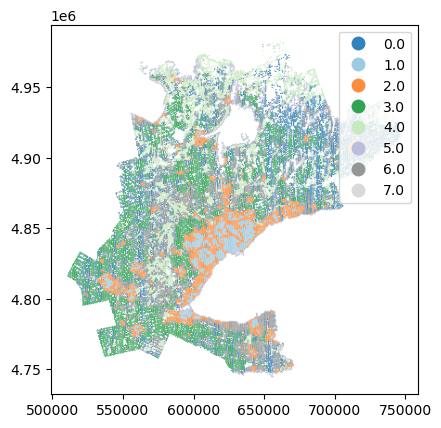

In [94]:
gpd.GeoDataFrame(final_grid).plot(column='Kmeans', legend=True, categorical=True, cmap='tab20c')

In [97]:
db = gpd.read_file("vectors\\dissemination_blocks_sam.shp")

In [113]:
db.iloc[:,-5:].columns

Index(['cy_ac_emp', 'pto_ac_emp', 'ptp_ac_emp', 'wa_ac_emp', 'geometry'], dtype='object')

In [103]:
db.iloc[:,-5:-1] = db.iloc[:,-5:-1].fillna(0)

In [106]:
from tobler.area_weighted import area_interpolate

interpolate =  final_grid

for coluna in db.iloc[:,-5:-1]:
    ct_area_interp_gdf = area_interpolate(source_df=db, 
                                          target_df=final_grid[,
                                          intensive_variables=[coluna])
    
    interpolate[coluna] = ct_area_interp_gdf[coluna]

In [114]:
interpolate = interpolate[['id','cy_ac_emp', 'pto_ac_emp', 'ptp_ac_emp', 'wa_ac_emp', 'geometry']]

In [ ]:
>>> from sklearn.preprocessing import MinMaxScaler
>>> data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
>>> scaler = MinMaxScaler()
>>> print(scaler.fit(data))
MinMaxScaler()
>>> print(scaler.data_max_)
[ 1. 18.]
>>> print(scaler.transform(data))
[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]
>>> print(scaler.transform([[2, 2]]))
[[1.5 0. ]]

In [125]:
scaler = MinMaxScaler()
interpolate.iloc[:,-5:-1] = scaler.fit(interpolate.iloc[:,-5:-1]).transform(interpolate.iloc[:,-5:-1])

In [126]:
interpolate

,id,cy_ac_emp,pto_ac_emp,ptp_ac_emp,wa_ac_emp,geometry
0,48948.0,0.009756,0.000189,0.000181,0.000469,"POLYGON ((612579.970 4890082.165, 612799.306 4..."
1,48951.0,0.005695,0.000245,0.000236,0.000753,"POLYGON ((612579.970 4887802.765, 612799.306 4..."
2,48950.0,0.013986,0.000603,0.000579,0.001849,"POLYGON ((612579.970 4888562.565, 612799.306 4..."
3,48953.0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((612579.970 4886283.165, 612799.306 4..."
4,48952.0,0.000000,0.000000,0.000000,0.000000,"POLYGON ((612579.970 4887042.965, 612799.306 4..."
...,...,...,...,...,...,...
53604,48945.0,0.002604,0.000302,0.000290,0.000616,"POLYGON ((612579.970 4892361.565, 612799.306 4..."
53605,48944.0,0.001881,0.000355,0.000341,0.000640,"POLYGON ((612579.970 4893121.365, 612799.306 4..."
53606,48947.0,0.006760,0.000138,0.000132,0.000496,"POLYGON ((612579.970 4890841.965, 612799.306 4..."
53607,48946.0,0.004983,0.000107,0.000103,0.000512,"POLYGON ((612579.970 4891601.765, 612799.306 4..."


In [130]:
interpolate.to_file("vectors/grid_sam.shp")

C:\Users\brdia\anaconda3\envs\environment\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [95]:
gpd.GeoDataFrame(final_grid[['id','Kmeans','geometry']]).to_file("vectors/grid_classified.shp")

C:\Users\brdia\anaconda3\envs\environment\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
final_grid.to_file("vectors/grid_classified_with_all_features.shp")

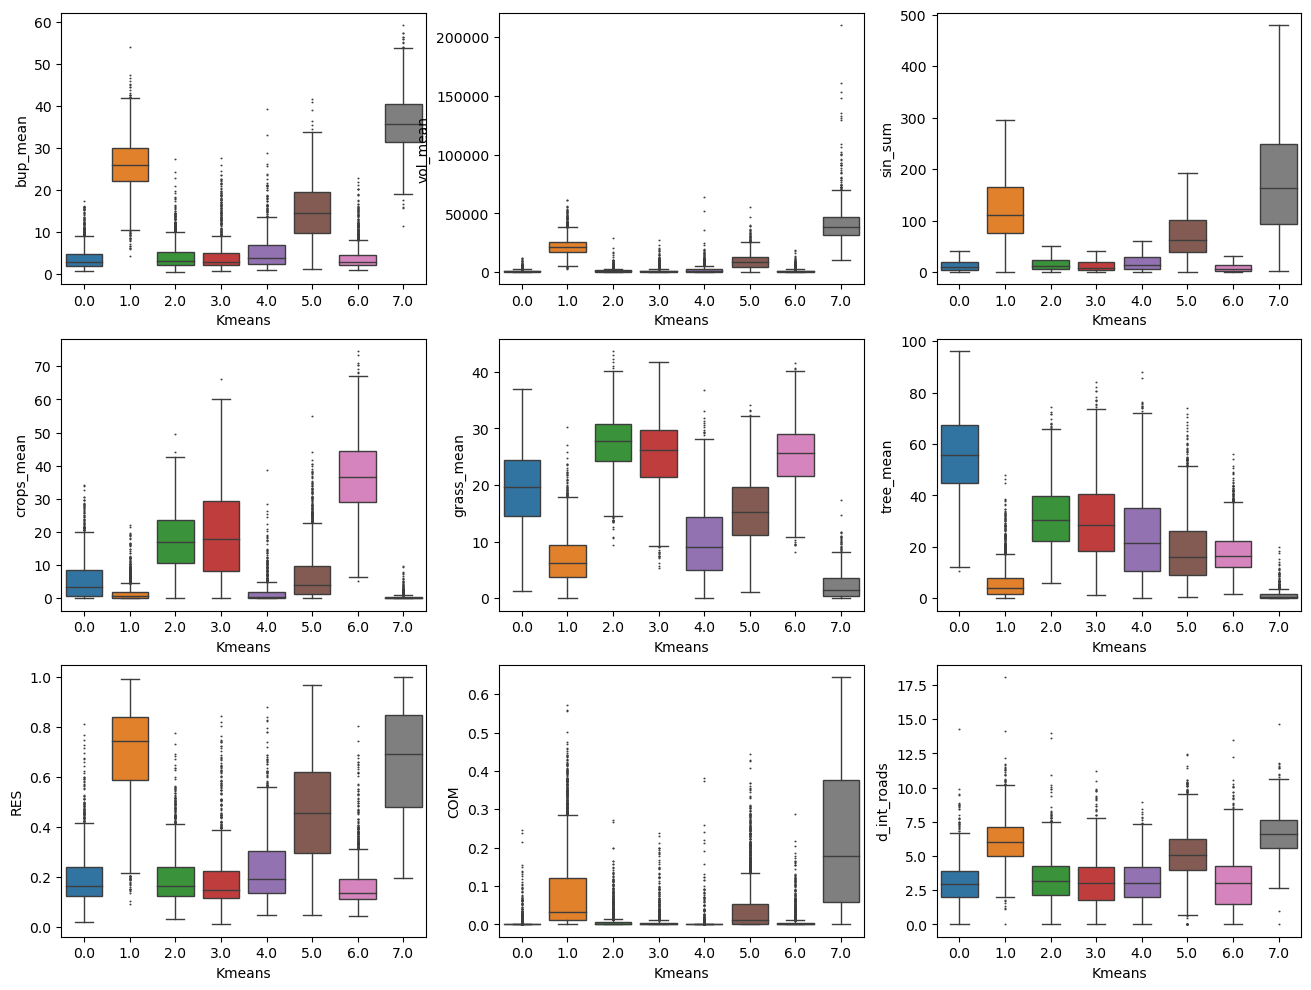

In [385]:
fig, axes = plt.subplots(3,3, figsize=(16, 12))

sns.boxplot(ax=axes[0,0], x='Kmeans', y= final_grid['bup_mean'],  
            linewidth = 1., fliersize = 0.5, data = final_grid)

sns.boxplot(ax=axes[0,1], x='Kmeans', y= final_grid['vol_mean'],  
            linewidth = 1,  fliersize = 0.5, data = final_grid)
axes[0,1]

sns.boxplot(ax=axes[0,2],x='Kmeans', y= final_grid['sin_sum'],  
            linewidth = 1,  fliersize = 0.5, data = final_grid, showfliers = False)
axes[0,2]

sns.boxplot(ax=axes[1,0], x='Kmeans', y= final_grid['crops_mean'],
            linewidth = 1,  fliersize = 0.5, data = final_grid)
axes[1,0]
sns.boxplot(ax=axes[1,1], x='Kmeans', y= final_grid['grass_mean'], 
            linewidth = 1,  fliersize = 0.5, data = final_grid)
axes[1,1]


sns.boxplot(ax=axes[1,2], x='Kmeans', y= final_grid['tree_mean'], linewidth = 1,  fliersize = 0.5, data = final_grid)
axes[1,2]

sns.boxplot(ax=axes[2,0], x='Kmeans', y= final_grid['RES'],  
            linewidth = 1,  fliersize = 0.5, data = final_grid)

sns.boxplot(ax=axes[2,1],x='Kmeans', y= final_grid['COM'], 
            linewidth = 1, fliersize = 0.5, data = final_grid)
axes[2,1]

sns.boxplot(ax=axes[2,2],x='Kmeans', y= final_grid['d_int_roads'],
            linewidth = 1, fliersize = 0.5, data = final_grid)
plt.show()